In [1]:
import os
os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home'

In [2]:
%%bash
echo $JAVA_HOME

/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home


### Session

In [3]:
from pyspark.sql import SparkSession

In [4]:
spark = SparkSession.builder.appName('MLTutorial').getOrCreate()

In [5]:
type(spark)

pyspark.sql.session.SparkSession

In [6]:
spark

### Data

In [7]:
from pyspark.sql.functions import avg, col, mean

In [38]:
# Load training data
df = spark.read.csv('titanic.csv', header=True, sep='\t', inferSchema=True)

In [39]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



### Feature engineering

In [40]:
df.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

In [41]:
df_stats = df.select(mean(col('Age')).alias('mean')).collect()

mean_age = round(df_stats[0]['mean'], 2)
mean_age

28.14

In [42]:
df = df.fillna(mean_age, subset=['Age'])

In [43]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

In [46]:
categoricalColumns = ["Pclass", "Sex", "Embarked"]

stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index', handleInvalid='keep')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
numericCols = ['Age', 'Pclass', 'SibSp', 'Parch', 'Fare']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [47]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['Survived', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- Survived: integer (nullable = true)
 |-- features: vector (nullable = true)



In [48]:
train, test = df.randomSplit([0.7, 0.3], seed = 20)

In [49]:
from pyspark.ml.classification import LogisticRegression

In [55]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, featuresCol='features', labelCol='Survived')

# Fit the model
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))


Coefficients: (13,[3,4],[-0.04663688030599067,0.06389504406308107])
Intercept: -0.6851421445608245


In [58]:
import matplotlib.pyplot as plt
import numpy as np

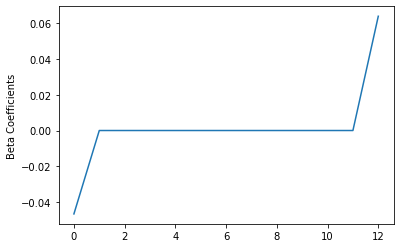

In [71]:

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()


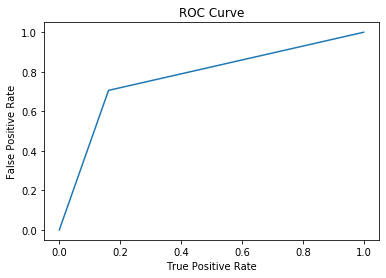

Training set areaUnderROC: 0.7720588235294118


In [72]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

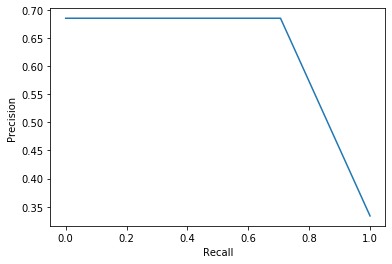

In [73]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [75]:
predictions = lrModel.transform(test)
predictions.show()

+--------+--------------------+--------------------+--------------------+----------+
|Survived|            features|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+--------------------+----------+
|       0|(13,[0,3,5,8,9,10...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,11...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.67519554587247...|       0.0|
|       0|(13,[0,3,5,8,9,12...|[0.73177902486681...|[0.6751955458

In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Survived', )
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8264705882352941
